___
Importing Libaries and Data

In [10]:
# !pip install jupyter tensorflow torch shap opencv-python keras-tuner
import os
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
from skimage import exposure
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras_tuner
import warnings
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Activation,Dropout,BatchNormalization,InputLayer
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adadelta  # Import Adadelta optimiser from TensorFlow
warnings.filterwarnings('ignore')

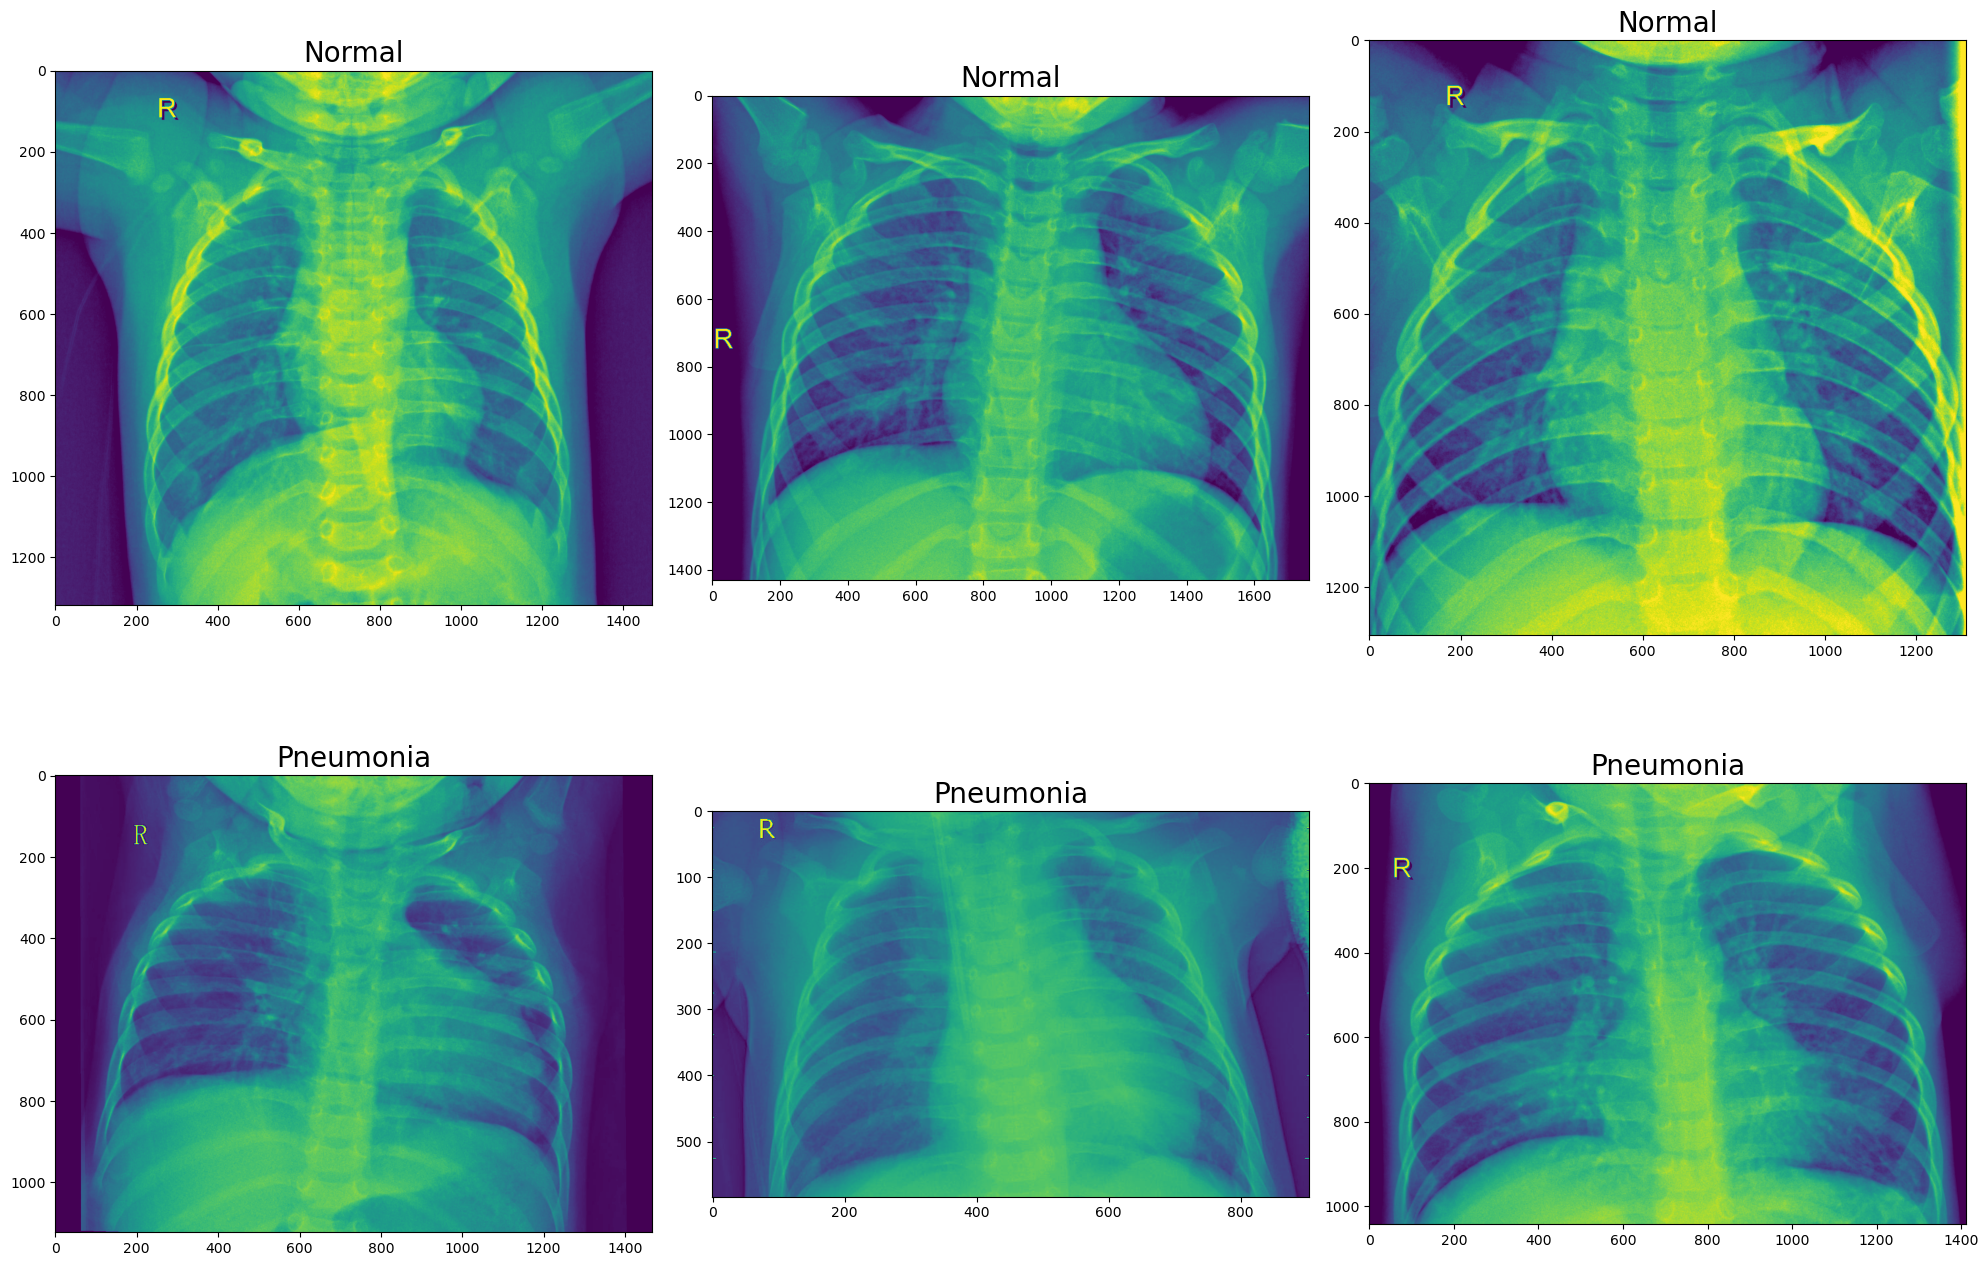

In [3]:
# Define paths to datasets for normal and pneumonia X-ray images
Normal_path = 'chest_xray/train/NORMAL/'
Pneumonia_path = 'chest_xray/train/PNEUMONIA/'

# Collect all image file paths from the 'NORMAL' directory
image_files = [os.path.join(Normal_path, filename) for filename in os.listdir(Normal_path)]
# Collect all image file paths from the 'PNEUMONIA' directory
image_files2 = [os.path.join(Pneumonia_path, filename) for filename in os.listdir(Pneumonia_path)]

# Define the number of images to randomly select
num_samples = 3

# Randomly select a specified number of images from each category
selected_images = random.sample(image_files, num_samples)
selected_images2 = random.sample(image_files2, num_samples)

# Create subplots to display the selected images in two rows
fig, axes = plt.subplots(2, num_samples, figsize=(20, 14))

# Display each selected normal image in the first row
for i, image_path in enumerate(selected_images):
    ax = axes[0, i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title('Normal', fontsize=20)  # Label the image as 'Normal'
    ax.axis('on')  # Enable the display of axes

# Display each selected pneumonia image in the second row
for i, image_path in enumerate(selected_images2):
    ax = axes[1, i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title('Pneumonia', fontsize=20)  # Label the image as 'Pneumonia'
    ax.axis('on')  # Enable the display of axes

# Adjust subplot layout to prevent overlapping and display the plot
plt.tight_layout()
plt.show()

___
EDA

In [4]:
# Set the path to the training directory where images are stored
train_dir = "chest_xray/train/"

# Initialise counters to keep track of the number of images in each category
normal_count = 0
pneumonia_count = 0

# Loop through directories within the training directory to count images in each category
for class_name in os.listdir(train_dir):
    # Construct the full path to the class directory
    class_path = os.path.join(train_dir, class_name)
    
    # Check if the path is a directory to avoid processing non-directory files
    if os.path.isdir(class_path):
        # Count images in the 'Normal' category
        if class_name.lower() == "normal":
            normal_count += len(os.listdir(class_path))
        # Count images in the 'Pneumonia' category
        elif class_name.lower() == "pneumonia":
            pneumonia_count += len(os.listdir(class_path))

# Output the count of images in each category
print("Number of samples in Normal class:", normal_count)
print("Number of samples in Pneumonia class:", pneumonia_count)

# Calculate and display the imbalance ratio between the two classes
imbalance_ratio = normal_count / pneumonia_count
print("Imbalance Ratio (Normal:Pneumonia):", imbalance_ratio)

Number of samples in Normal class: 1341
Number of samples in Pneumonia class: 3875
Imbalance Ratio (Normal:Pneumonia): 0.3460645161290323


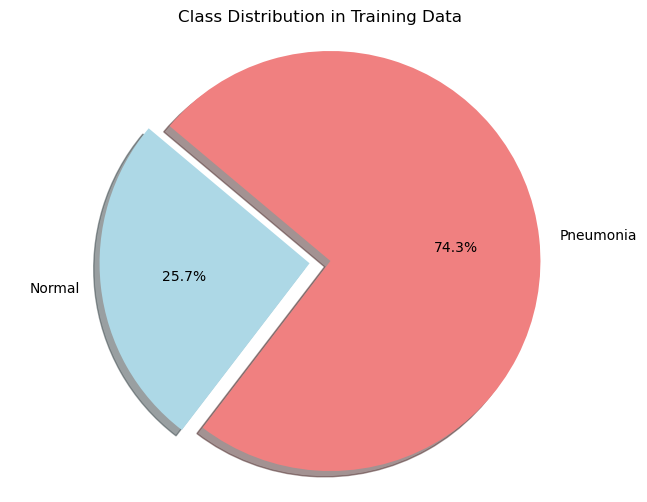

In [5]:
# Set the path to the directory containing training data
train_dir = "chest_xray/train"

# Initialise counters to track the number of images in each category
normal_count = 0
pneumonia_count = 0

# Iterate over each subdirectory in the training directory
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)  # Construct the full path to the class directory
    if os.path.isdir(class_path):  # Check if the path is a directory to filter out files
        if class_name.lower() == "normal":  # Identify the 'Normal' class and update its count
            normal_count += len(os.listdir(class_path))
        elif class_name.lower() == "pneumonia":  # Identify the 'Pneumonia' class and update its count
            pneumonia_count += len(os.listdir(class_path))

# Prepare labels and data for the pie chart to visualize class distribution
labels = ['Normal', 'Pneumonia']  # Define labels for the pie chart
sizes = [normal_count, pneumonia_count]  # Data points for the pie chart
colors = ['lightblue', 'lightcoral']  # Colors for each slice
explode = (0, 0.1)  # Emphasize the 'Pneumonia' slice by exploding it out

# Plotting configuration for the pie chart
plt.figure(figsize=(8, 6))  # Set the figure size
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Ensure the pie chart is a circle by setting equal aspect ratio
plt.title('Class Distribution in Training Data')  # Title for the pie chart
plt.show()  # Display the pie chart

___
Pre Processing

In [6]:
# Set the batch size for processing images
batch_size = 8

# Configure the training data generator with data augmentation options
train_datagen = ImageDataGenerator(
    rotation_range=40,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
    rescale=1./255,  # Scale the images by normalizing pixel values to [0, 1]
    shear_range=0.2,  # Apply shearing transformations
    zoom_range=0.2,  # Randomly zoom into images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Use the nearest fill mode to fill gaps created by the above transformations
)

# Configure the validation data generator without augmentation, only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

# Configure the test data generator, identical to validation generator with only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a training data generator to fetch images from directory with defined transformations
train_generator = train_datagen.flow_from_directory(
    directory='chest_xray/train',  # Path to training data
    target_size=(300, 300),  # Resize images to 300x300
    batch_size=batch_size,  # Batch size for training
    color_mode='grayscale',  # Convert images to grayscale
    class_mode='binary'  # Use binary labels for the binary classification problem
)

# Create a validation data generator for fetching images from directory with no augmentation
validation_generator = val_datagen.flow_from_directory(
    'chest_xray/chest_xray/val',  # Path to validation data
    target_size=(300, 300),  # Resize images to 300x300
    batch_size=batch_size,  # Batch size for validation
    color_mode='grayscale',  # Convert images to grayscale
    class_mode='binary'  # Use binary labels for the binary classification problem
)

# Create a test data generator for fetching images from directory with no augmentation
test_generator = test_datagen.flow_from_directory(
    'chest_xray/chest_xray/test',  # Path to test data
    target_size=(300, 300),  # Resize images to 300x300
    batch_size=batch_size,  # Batch size for testing
    color_mode='grayscale',  # Convert images to grayscale
    class_mode='binary'  # Use binary labels for the binary classification problem
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


___
Developing CNN Model

In [7]:
# Initialise a Sequential model to build a convolutional neural network (CNN)
cnn_model = Sequential()

# Add a convolutional layer with L2 regularisation and He normal initialiser
cnn_model.add(Conv2D(256,kernel_size=(3,3),padding='same',activation='relu',input_shape=(300,300,1),kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
cnn_model.add(BatchNormalization()) # Add batch normalisation to normalise activations
cnn_model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same')) # Add pooling layer to reduce spatial dimensions

# Add additional convolutional layers with similar settings for deep feature extraction
cnn_model.add(Conv2D(164,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))

cnn_model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))

# Repeat the pattern to increase the depth of the network
cnn_model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))

# Flatten the output from the convolutional layers to feed into dense layers
cnn_model.add(Flatten())

# Add dense layers with L2 regularisation and dropout for regularisation
cnn_model.add(Dense(164,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.2)) # Apply dropout to prevent overfitting

cnn_model.add(Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.2))

# Add more dense layers with the same configuration
cnn_model.add(Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.2))

cnn_model.add(Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
cnn_model.add(BatchNormalization())

# Add the output layer with a sigmoid activation for binary classification
cnn_model.add(Dense(1,activation='sigmoid'))

2024-04-25 17:17:26.016404: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-25 17:17:26.016439: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-25 17:17:26.016447: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-25 17:17:26.016476: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-25 17:17:26.016506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
# Initialise the Adadelta optimiser with a specified learning rate and decay factor
optimiser = Adadelta(learning_rate=1.0, rho=0.95)

# Compile the model specifying the optimiser, loss function, and metrics to monitor
cnn_model.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy'])

# Set up an early stopping callback to halt training when validation performance stops improving
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)

# List of callbacks to be used during training
CALLBACKS = [early_stopping_cb]

# Start training the model using the previously defined train and test generators
cnn_history = cnn_model.fit(
    train_generator,  # Training data source
    callbacks=CALLBACKS,  # Callbacks to control the training dynamics
    epochs=2,  # Total number of epochs to train for 33/100 1/3
    validation_data=test_generator  # Data for validation in each epoch
)

Epoch 1/2


2024-04-25 17:17:32.686304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


652/652 ━━━━━━━━━━━━━━━━━━━━ 305s 462ms/step - accuracy: 0.7237 - loss: 2.3958 - val_accuracy: 0.8526 - val_loss: 1.8342
Epoch 2/2
652/652 ━━━━━━━━━━━━━━━━━━━━ 299s 458ms/step - accuracy: 0.8396 - loss: 1.6911 - val_accuracy: 0.5673 - val_loss: 2.4335


In [12]:

cnn_model.save('CNN_Model.keras')
with open('CNN_history.pkl', 'wb') as f:
    pickle.dump(cnn_history.history, f)

# This method displays the structure of the neural network, showing each layer, its type, output shape, and number of parameters.
cnn_model.summary()  

# Evaluate the model on the data provided by validation_generator to determine loss and accuracy.
cnn_evaluation = cnn_model.evaluate(validation_generator)  
# This line will output the result of model.evaluate, typically a list where the first element is loss and the second is accuracy.
cnn_evaluation  

# Print a formatted string showing the accuracy of the model as a percentage. The accuracy is accessed from the second element of the Evaluation list and multiplied by 100 to convert it to a percentage.
print("Accracy of this model is :", cnn_evaluation[1]*100, "%")  

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 300, 300, 256)  │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 300, 300, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 164)  │       378,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 164)  │           656 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 164)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        94,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 23104)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 164)            │     3,789,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 164)            │           656 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 164)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        21,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 13,005,725 (49.61 MB)

 Trainable params: 4,334,617 (16.54 MB)

 Non-trainable params: 1,872 (7.31 KB)

 Optimizer params: 8,669,236 (33.07 MB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.8750 - loss: 1.7324
Accracy of this model is : 87.5 %


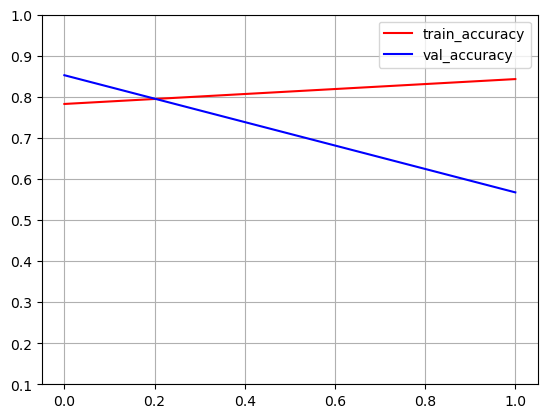

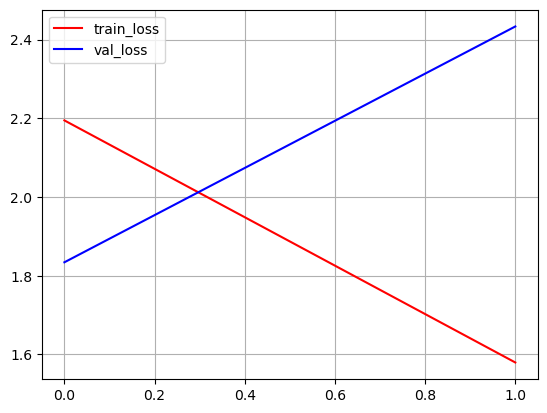

<Axes: >

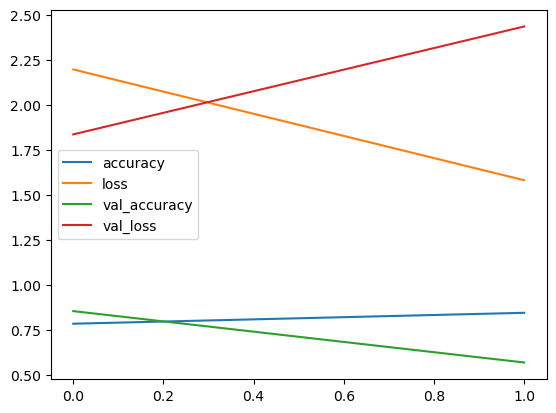

In [13]:
# Plot training and validation accuracy
plt.plot(cnn_history.history['accuracy'], color='red', label='train_accuracy')  # Plot training accuracy in red
plt.plot(cnn_history.history['val_accuracy'], color='blue', label='val_accuracy')  # Plot validation accuracy in blue
plt.legend()  # Display the legend to differentiate train and validation lines
plt.grid()  # Add grid lines for better readability

# Set y-axis limits from 0.1 to 1.0
plt.ylim(0.1, 1.0)  # Set the limits for the y-axis to range from 0.1 to 1.0

plt.show()  # Display the plot for accuracy

# Plot training and validation loss
plt.plot(cnn_history.history['loss'], color='red', label='train_loss')  # Plot training loss in red
plt.plot(cnn_history.history['val_loss'], color='blue', label='val_loss')  # Plot validation loss in blue
plt.legend()  # Show the legend to identify train vs validation loss
plt.grid()  # Enable grid lines for ease of viewing

# No need for plt.plot() here as it does nothing without arguments.
plt.show()  # Display the plot for loss

# Plot all data from history using DataFrame
pd.DataFrame(cnn_history.history).plot()  # Create a DataFrame from history and plot all metrics


___
Predictions

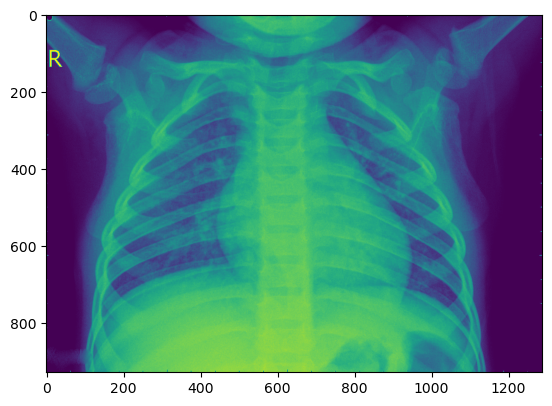

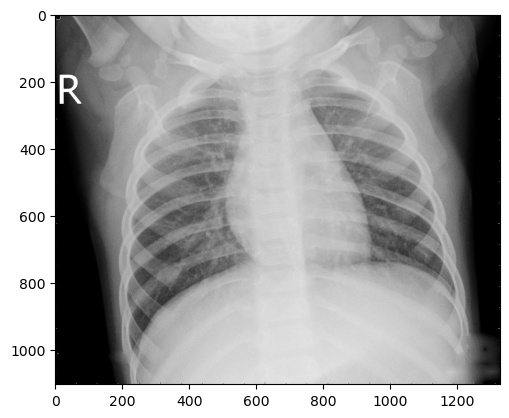

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted classes:
['Negative']


In [16]:
# Specify the path to the image file
Normal_xray_path = 'chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg'

# Read the image using imread
Normal_xray_image = mpimg.imread(Normal_xray_path)

# Display the image using imshow
plt.imshow(Normal_xray_image)
plt.show()

# Specify the path to the image file
Normal_xray_path = 'chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg'

# Read the image using OpenCV
Normal_xray_image = cv2.imread(Normal_xray_path)

# Convert the image to grayscale
Normal_xray_image_gray = cv2.cvtColor(Normal_xray_image, cv2.COLOR_BGR2GRAY)


# Normalize the resized image
resized_image_normalized = Normal_xray_image_gray / 255.0

# Resize the image to match the desired dimensions
resized_image = cv2.resize(resized_image_normalized, (300, 300))

# Reshape the image to match the expected input shape of the model
resized_image = resized_image.reshape(-1,300, 300, 1)

# Convert the data type to float32
resized_image = resized_image.astype(np.float32)

# Display the resized grayscale image
plt.imshow(resized_image_normalized, cmap='gray')
plt.axis('on')
plt.show()

cnn_predictions = cnn_model.predict(resized_image)

# Convert predictions to binary labels
cnn_predicted_classes = (cnn_predictions > 0.5).astype("int")

# Optionally, map these integers to class labels for clearer interpretation
class_labels = ['Negative', 'Positive']  # Define what each class integer represents
cnn_predicted_labels = [class_labels[i] for i in cnn_predicted_classes.flatten()]  # Flatten is used if predictions come in a multi-dimensional array form

# Print each prediction clearly
print("Predicted classes:")
print(cnn_predicted_labels)

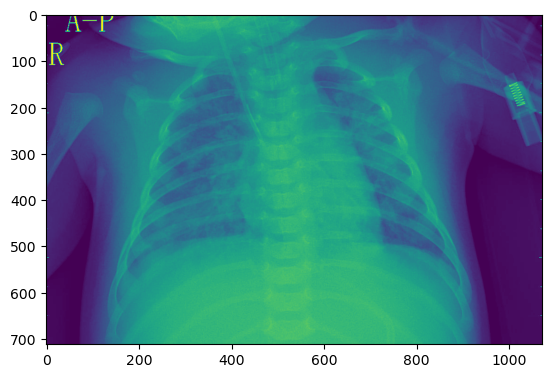

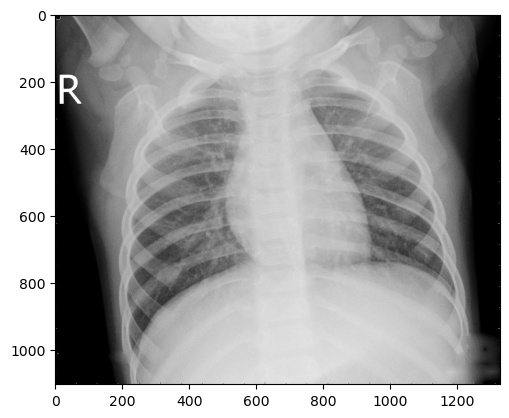

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted classes:
['Positive']


In [17]:
# Specify the path to the image file
Pneumonia_xray_path = 'chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg'

# Read the image using imread
Pneumonia_xray_image = mpimg.imread(Pneumonia_xray_path)

# Display the image using imshow
plt.imshow(Pneumonia_xray_image)
plt.show()

# Specify the path to the image file
Pneumonia_xray_path = 'chest_xray/train/PNEUMONIA/person1004_bacteria_2935.jpeg'

# Read the image using OpenCV
Pneumonia_xray_image = cv2.imread(Pneumonia_xray_path)

# Convert the image to grayscale
Pneumonia_xray_image_gray = cv2.cvtColor(Pneumonia_xray_image, cv2.COLOR_BGR2GRAY)

# Normalize the resized image
Pneumonia_xray_image_normalized = Pneumonia_xray_image_gray / 255.0

# Resize the image to match the desired dimensions
resized_image = cv2.resize(Pneumonia_xray_image_normalized, (300, 300))

# Reshape the image to match the expected input shape of the model
resized_image = resized_image.reshape(-1, 300, 300, 1)

# Convert the data type to float32
resized_image = resized_image.astype(np.float32)

# Display the resized grayscale image
plt.imshow(resized_image_normalized, cmap='gray')
plt.axis('on')
plt.show()

cnn_predictions = cnn_model.predict(resized_image)

# Convert predictions to binary labels
cnn_predicted_classes = (cnn_predictions > 0.5).astype("int")

# Optionally, map these integers to class labels for clearer interpretation
class_labels = ['Negative', 'Positive']  # Define what each class integer represents
cnn_predicted_labels = [class_labels[i] for i in cnn_predicted_classes.flatten()]  # Flatten is used if predictions come in a multi-dimensional array form

# Print each prediction clearly
print("Predicted classes:")
print(cnn_predicted_labels)

___
VGG

Pre Processing

In [21]:
# Define the parameters for image data augmentation
vgg_train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    shear_range=0.2,  # Apply random shearing transformations
    zoom_range=0.2,   # Apply random zooming
    horizontal_flip=True  # Randomly flip images horizontally
)

# Create the training generator
vgg_train_generator = vgg_train_datagen.flow_from_directory(
    'chest_xray/train',  # Update this to your actual directory path
    target_size=(300, 300),  # All images will be resized to 300x300
    batch_size=8,  # Number of images to process in a batch
    class_mode='binary'  # Type of classification (binary in this case)
)

# Now, define the validation and testing generators as needed, without augmentation but with rescaling
vgg_val_datagen = ImageDataGenerator(rescale=1./255)
vgg_validation_generator = vgg_val_datagen.flow_from_directory(
    'chest_xray/chest_xray/val',  # Update this to your actual directory path
    target_size=(300, 300),
    batch_size=8,
    class_mode='binary'
)

# Setup the test data generator, similar to the validation generator but for test data
vgg_test_datagen = ImageDataGenerator(rescale=1./255)
vgg_test_generator = vgg_test_datagen.flow_from_directory(
    'chest_xray/chest_xray/test',  # Ensure this is the path to your test dataset
    target_size=(300, 300),
    batch_size=8,
    class_mode='binary',
    shuffle=False  # Typically, you don't shuffle the test set if you're evaluating or predicting
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [22]:
def create_vgg_model():
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=( 300, 300, 3)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        # Final classifier
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the VGG model
vgg_model = create_vgg_model()

In [23]:
# Train the model
vgg_history = vgg_model.fit(
    vgg_train_generator,
    epochs=2,
    validation_data=vgg_validation_generator
)

Epoch 1/2
652/652 ━━━━━━━━━━━━━━━━━━━━ 99s 147ms/step - accuracy: 0.7681 - loss: 0.5766 - val_accuracy: 0.8125 - val_loss: 0.5759
Epoch 2/2
652/652 ━━━━━━━━━━━━━━━━━━━━ 96s 146ms/step - accuracy: 0.8905 - loss: 0.2893 - val_accuracy: 0.8125 - val_loss: 0.6511


In [24]:
vgg_model.save('VGG_Model.keras')
with open('VGG_history.pkl', 'wb') as f:
    pickle.dump(vgg_history.history, f)

vgg_model.summary() 

# Evaluate the model on the data provided by validation_generator to determine loss and accuracy.
vgg_evaluation = vgg_model.evaluate(vgg_validation_generator)  
# This line will output the result of model.evaluate, typically a list where the first element is loss and the second is accuracy.
vgg_evaluation  

# Print a formatted string showing the accuracy of the model as a percentage. The accuracy is accessed from the second element of the Evaluation list and multiplied by 100 to convert it to a percentage.
print("Accracy of this model is :", vgg_evaluation[1]*100, "%")  

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 300, 300, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 300, 300, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 175232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │    22,429,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,150,885 (259.97 MB)

 Trainable params: 22,716,961 (86.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 45,433,924 (173.32 MB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8333 - loss: 0.5211
Accracy of this model is : 81.25 %


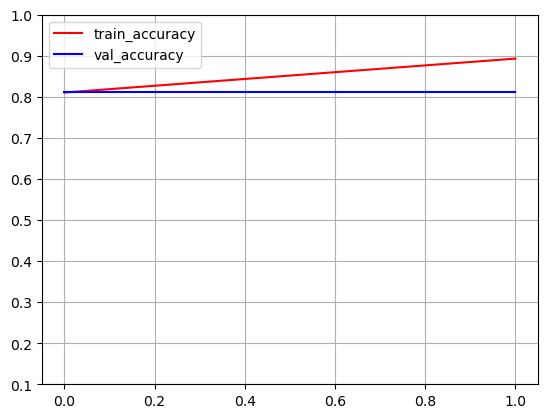

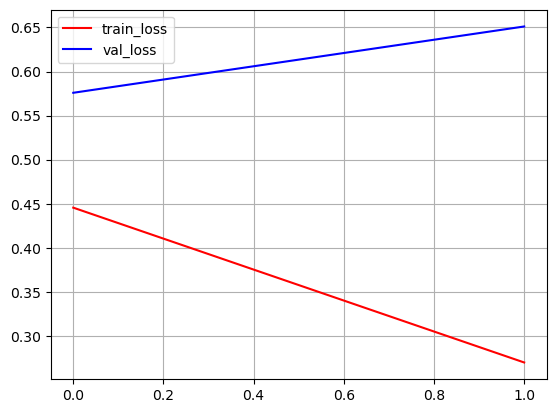

<Axes: >

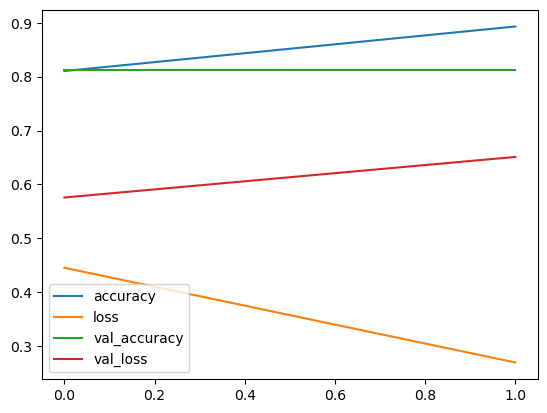

In [25]:
# Plot training and validation accuracy
plt.plot(vgg_history.history['accuracy'], color='red', label='train_accuracy')  # Plot training accuracy in red
plt.plot(vgg_history.history['val_accuracy'], color='blue', label='val_accuracy')  # Plot validation accuracy in blue
plt.legend()  # Display the legend to differentiate train and validation lines
plt.grid()  # Add grid lines for better readability

# Set y-axis limits from 0.1 to 1.0
plt.ylim(0.1, 1.0)  # Set the limits for the y-axis to range from 0.1 to 1.0

plt.show()  # Display the plot for accuracy

# Plot training and validation loss
plt.plot(vgg_history.history['loss'], color='red', label='train_loss')  # Plot training loss in red
plt.plot(vgg_history.history['val_loss'], color='blue', label='val_loss')  # Plot validation loss in blue
plt.legend()  # Show the legend to identify train vs validation loss
plt.grid()  # Enable grid lines for ease of viewing

# No need for plt.plot() here as it does nothing without arguments.
plt.show()  # Display the plot for loss

# Plot all data from history using DataFrame
pd.DataFrame(vgg_history.history).plot()  # Create a DataFrame from history and plot all metrics


___
Predictions

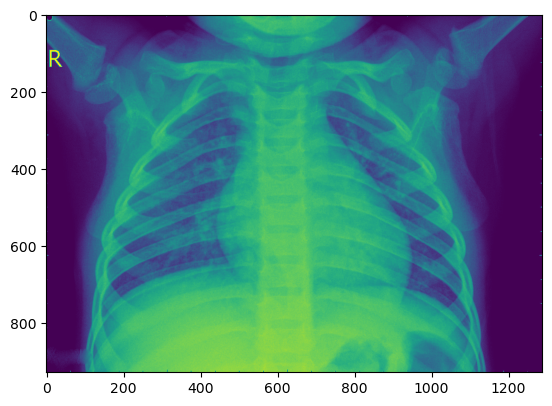

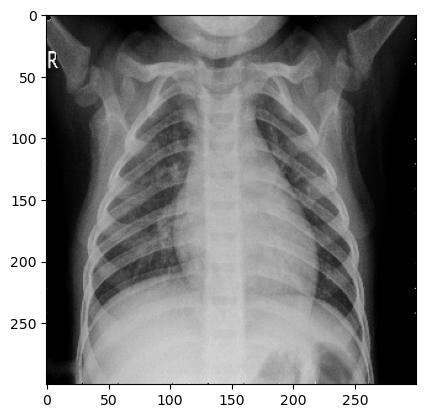

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Predicted classes:
['Positive']


In [26]:
# Specify the path to the image file
Normal_xray_path = 'chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg'

# Read the image using imread
Normal_xray_image = mpimg.imread(Normal_xray_path)

# Display the image using imshow
plt.imshow(Normal_xray_image)
plt.show()

# Read the image using OpenCV
Normal_xray_image = cv2.imread(Normal_xray_path)

# Normalize the image
Normal_xray_image_normalized = Normal_xray_image / 255.0

# Resize the image to match the desired dimensions
resized_image = cv2.resize(Normal_xray_image_normalized, (300, 300))

# Reshape the image to match the expected input shape of the model
# Note that we're keeping the 3 channels here
resized_image = resized_image.reshape(-1, 300, 300, 3)

# Convert the data type to float32
resized_image = resized_image.astype(np.float32)

# Display the resized image
plt.imshow(cv2.cvtColor(resized_image[0], cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for correct color display
plt.axis('on')
plt.show()

vgg_predictions = vgg_model.predict(resized_image)

# Convert predictions to binary labels
vgg_predicted_classes = (vgg_predictions > 0.5).astype("int")

# Optionally, map these integers to class labels for clearer interpretation
class_labels = ['Negative', 'Positive']  # Define what each class integer represents
vgg_predicted_classes = [class_labels[i] for i in vgg_predicted_classes.flatten()]  # Flatten is used if predictions come in a multi-dimensional array form

# Print each prediction clearly
print("Predicted classes:")
print(vgg_predicted_classes)

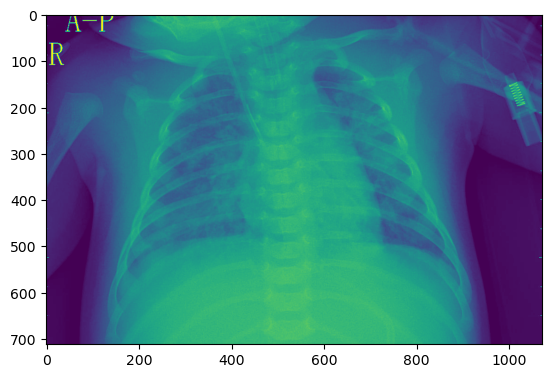

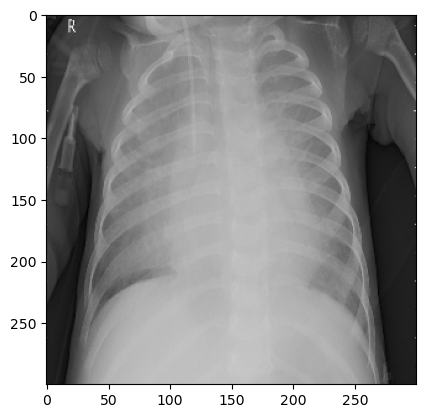

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted classes:
['Positive']


In [53]:
# Specify the path to the image file and read the image
Pneumonia_xray_path_1 = 'chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg'
Pneumonia_xray_image_1 = mpimg.imread(Pneumonia_xray_path_1)

# Display the first image using imshow
plt.imshow(Pneumonia_xray_image_1)
plt.show()

# Specify the path to another image file and read the image
Pneumonia_xray_path_2 = 'chest_xray/train/PNEUMONIA/person1004_bacteria_2935.jpeg'
Pneumonia_xray_image_2 = cv2.imread(Pneumonia_xray_path_2)

# Normalize the image by dividing by 255.0
Pneumonia_xray_image_normalized_2 = Pneumonia_xray_image_2 / 255.0

# Resize the image to match the desired dimensions
resized_image_2 = cv2.resize(Pneumonia_xray_image_normalized_2, (300, 300))

# Reshape the image to match the expected input shape of the CNN model
# Here we keep the 3 color channels
resized_image_2 = resized_image_2.reshape(-1, 300, 300, 3)

# Convert the data type to float32
resized_image_2 = resized_image_2.astype(np.float32)

# Display the resized image
plt.imshow(cv2.cvtColor(resized_image_2[0], cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for correct color display
plt.axis('on')
plt.show()

# Assuming cnn_model is already defined and compiled
vgg_predictions = vgg_model.predict(resized_image_2)

# Convert predictions to binary labels
vgg_predicted_classes = (vgg_predictions > 0.5).astype("int")

# Optionally, map these integers to class labels for clearer interpretation
class_labels = ['Negative', 'Positive']  # Define what each class integer represents
vgg_predicted_labels = [class_labels[i] for i in vgg_predicted_classes.flatten()]  # Flatten is used if predictions come in a multi-dimensional array form

# Print each prediction clearly
print("Predicted classes:")
print(vgg_predicted_labels)

In [54]:
# Accessing the history dictionary
history_dict = cnn_history.history

# Printing all keys and their corresponding values
for key in history_dict:
    print(f"{key}: {history_dict[key]}")

accuracy: [0.7825919985771179, 0.8431748747825623]
loss: [2.1948084831237793, 1.5795623064041138]
val_accuracy: [0.8525640964508057, 0.567307710647583]
val_loss: [1.8341925144195557, 2.4334940910339355]


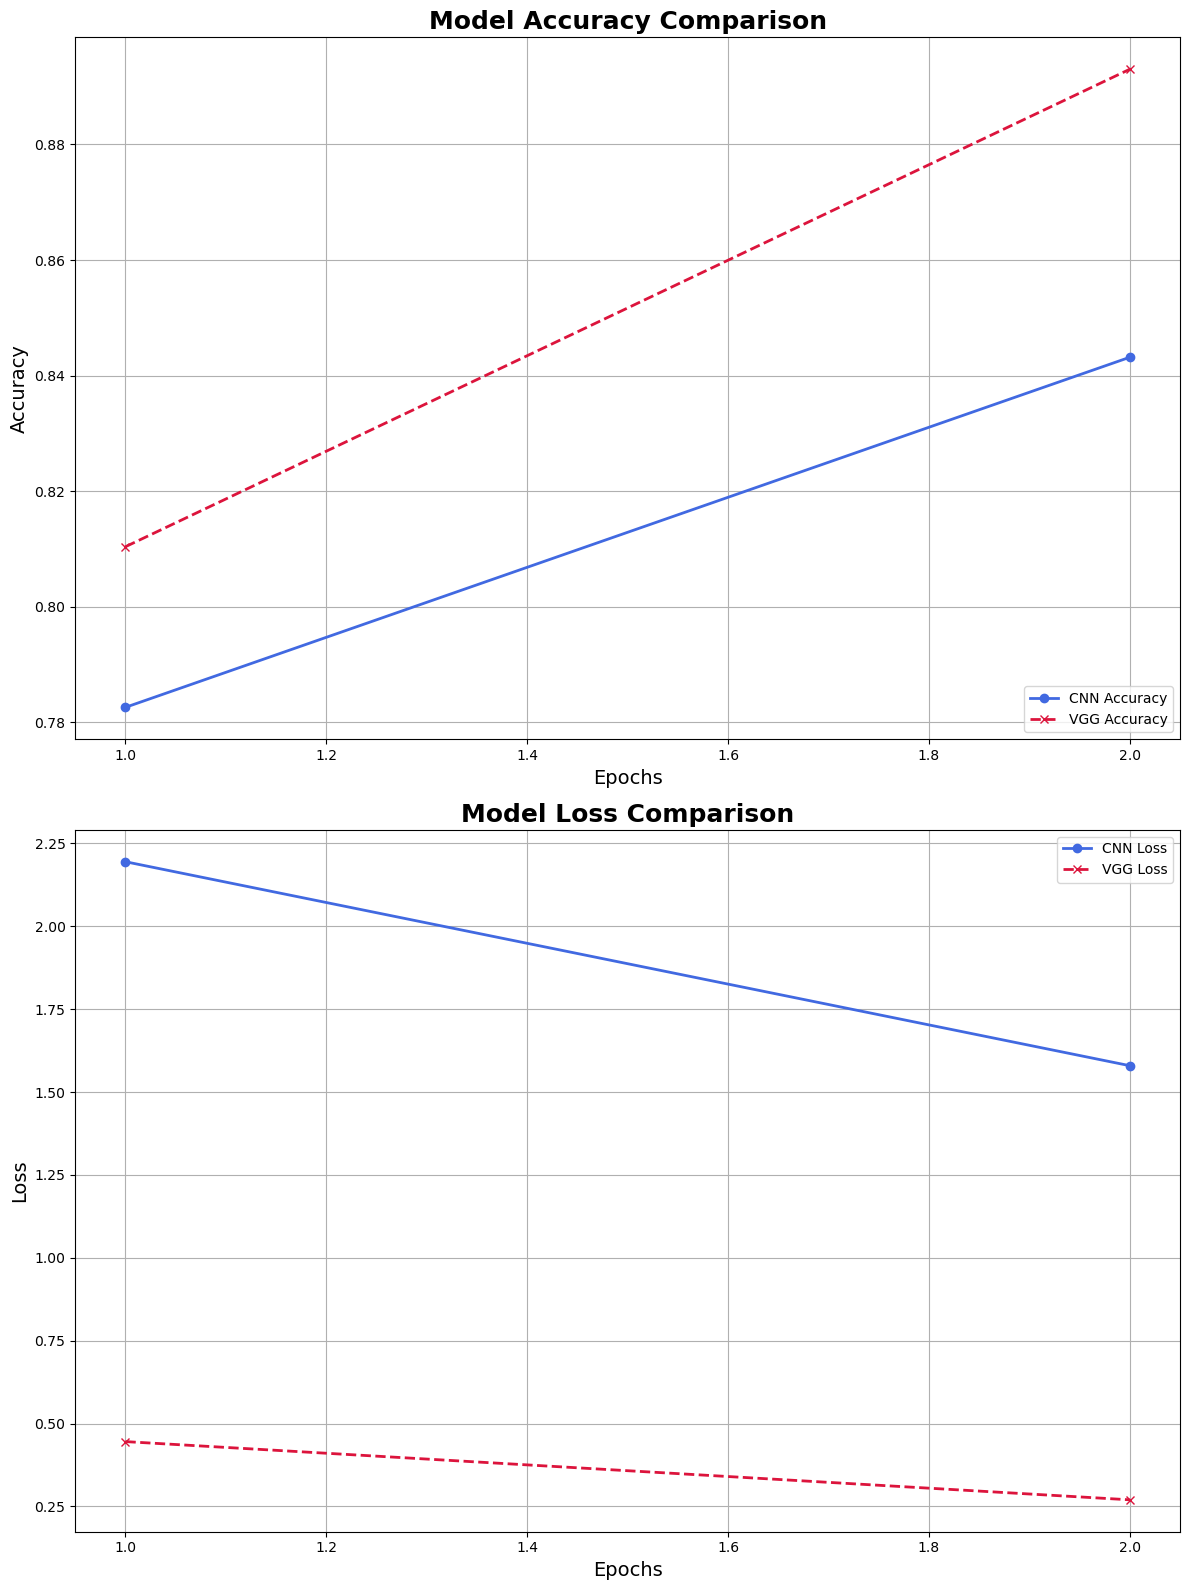

In [72]:
# Define epochs based on the length of one of your history metrics
epochs = np.arange(1, len(cnn_history.history['accuracy']) + 1)

# Metrics for CNN
accuracy_cnn = cnn_history.history['accuracy']
loss_cnn = cnn_history.history['loss']

# Metrics for VGG
accuracy_vgg = vgg_history.history['accuracy']
loss_vgg = vgg_history.history['loss']

# Setting up a nicer color palette
colors = {'CNN': 'royalblue', 'VGG': 'crimson'}
line_styles = {'CNN': {'line': '-', 'marker': 'o'}, 'VGG': {'line': '--', 'marker': 'x'}}
line_width = 2

# Plotting setup
fig, axs = plt.subplots(2, 1, figsize=(12, 16))  # Adjust size for better display

# Plot Accuracy
axs[0].plot(epochs, accuracy_cnn, label='CNN Accuracy', color=colors['CNN'], linestyle=line_styles['CNN']['line'], marker=line_styles['CNN']['marker'], linewidth=line_width, markersize=6)
axs[0].plot(epochs, accuracy_vgg, label='VGG Accuracy', color=colors['VGG'], linestyle=line_styles['VGG']['line'], marker=line_styles['VGG']['marker'], linewidth=line_width, markersize=6)
axs[0].set_title('Model Accuracy Comparison', fontsize=18, fontweight='bold')
axs[0].set_xlabel('Epochs', fontsize=14)
axs[0].set_ylabel('Accuracy', fontsize=14)
axs[0].legend(loc='lower right')
axs[0].grid(True)

# Plot Loss
axs[1].plot(epochs, loss_cnn, label='CNN Loss', color=colors['CNN'], linestyle=line_styles['CNN']['line'], marker=line_styles['CNN']['marker'], linewidth=line_width, markersize=6)
axs[1].plot(epochs, loss_vgg, label='VGG Loss', color=colors['VGG'], linestyle=line_styles['VGG']['line'], marker=line_styles['VGG']['marker'], linewidth=line_width, markersize=6)
axs[1].set_title('Model Loss Comparison', fontsize=18, fontweight='bold')
axs[1].set_xlabel('Epochs', fontsize=14)
axs[1].set_ylabel('Loss', fontsize=14)
axs[1].legend(loc='upper right')
axs[1].grid(True)

plt.tight_layout()
plt.show()

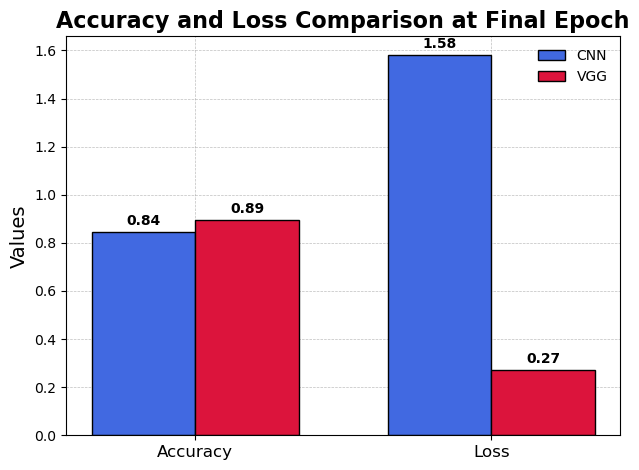

In [74]:
# Assuming you have the final epoch's metrics loaded in these variables
final_accuracy_cnn = accuracy_cnn[-1]
final_accuracy_vgg = accuracy_vgg[-1]
final_loss_cnn = loss_cnn[-1]
final_loss_vgg = loss_vgg[-1]

labels = ['Accuracy', 'Loss']
cnn_values = [final_accuracy_cnn, final_loss_cnn]
vgg_values = [final_accuracy_vgg, final_loss_vgg]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cnn_values, width, label='CNN', color='royalblue', edgecolor='black')
rects2 = ax.bar(x + width/2, vgg_values, width, label='VGG', color='crimson', edgecolor='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Values', fontsize=14)
ax.set_title('Accuracy and Loss Comparison at Final Epoch', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend(frameon=False, loc='best')

# Adding labels on top of each bar for better readability
for rect in rects1:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

for rect in rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Improving overall aesthetics
ax.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.5)
ax.set_axisbelow(True)  # Ensure grid is behind the bars

fig.tight_layout()
plt.show()